## Введение в обработку естественного языка

Домашнее задание №4

Урок 4. Тематическое моделирование. EM-алгоритм

*Формат именования файла домашней работы: FIO_NLP_HW_N.ipynb, где N - номер домашнего задания*

**

1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

**Установка и импорт необходимых библиотек**

In [1]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 40.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=2740782596a66887618992b411a9f76d59379ca3f286d6bbf9ef6540bb4b0502
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [2]:
import requests
from bs4 import BeautifulSoup 
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import re
import string
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize

Загрузка данных

In [3]:
## найти id каждого вопроса на страницах

page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]
    
urls = []
for page in tqdm(range(1, 500), desc='Pages'):
    time.sleep(0.5)
    res = requests.get(main_url.format(page=page))  
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

Pages:   0%|          | 0/499 [00:00<?, ?it/s]

In [4]:
## имея id запросов достанем тексты на страницах

domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

question = []
answer = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))  
    soup = BeautifulSoup(res.text)
    
    question.append(get_text_page_question(soup))
    try:
        answer.append(get_text_page_answer(soup))
    except:
        answer.append('No answer')

Pages:   0%|          | 0/2495 [00:00<?, ?it/s]

In [5]:
# df = pd.DataFrame(list(zip(question, answer)), columns=['question','answer'])
df = pd.DataFrame(question, columns=['question'])

In [6]:
df.to_csv('rospotrebnadzor.csv', index=False)

In [7]:
df = pd.read_csv('rospotrebnadzor.csv')

In [8]:
df

,question
0,Добрый день.Существует такая Пекарня в г.Киров...
1,"Добрый день. Я, Елена Станиславовна Кубланова,..."
2,Сделали заказ 01 апреля 2023г. на сайте rc-go...
3,Прошу провести проверку в одном из магазинов «...
4,"Заказ был на женские джинсы размера xs, забрал..."
...,...
2490,"Добрый день! Поясните пожалуйста, в каком случ..."
2491,Здравствуйте! Сегодня мною был приобретён дива...
2492,"Здравствуйте, я купила абонемент на процедуру ..."
2493,Был заказ № 87390\r\nот 29.06.2022 детские бот...


In [9]:
nltk.download('stopwords')
words_regex = re.compile('\w+')
morph = MorphAnalyzer()
my_stopwords = ['здравствуйте', 'добрый', 'день', 'вопрос', 'роспотребнадзор', 'либо', 'месяц', 
                'течение', 'данный', 'это', 'просить', 'сказать', 'год', 'адрес', 'обращение', 'мочь', 'иметь', 'человек',
                'право', 'санкт' ,'петербург']

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian') + my_stopwords

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
df.question.iloc[1]

'Добрый день. Я, Елена Станиславовна Кубланова, - постоянный покупатель на маркетплейсе Вайлдберриз. 17 марта 2023 года я приобрела корм для собаки ProBalance Hypoallergenic для собак 15кг. Артикул: 140843311, сумма покупки 4374 руб. Продавец - СЕМЁРОЧКА - ИП Симонян Г. Д., ОГРНИП: 321344300064223. На фотографии оборотной стороны упаковки в карточке товара на сайте Вайлдберриз ясно видна информация о дате изготовления, номере партии товара. Я же получила товар, на оборотной стороне которого указана другая информация, которую продавцом ИП Симонян Г. Д. рекомендовано считать приоритетной: Изготовитель – ЗАО «Алейскзернопродукт», г. Алейск Алтайского края. На официальном сайте производителя корма ProBalance Hypoallergenic – компании ООО «ВЭЛКОРМ» - сайт https://delo-korm.ru/ - указано расположение только двух производств в России: г. Санкт-Петербург, г. Тверь. Ни о каком производстве данного корма в г. Алейске Алтайского края нет вообще никакой информации. Дозвонились и в компанию ООО «ВЭ

In [11]:
print(preprocess(df.question.iloc[1]))

['елена', 'станиславович', 'кублановый', 'постоянный', 'покупатель', 'маркетплейс', 'вайлдберриз', 'март', 'приобрести', 'корм', 'собака', 'probalance', 'hypoallergenic', 'собака', 'артикул', 'сумма', 'покупка', 'руб', 'продавец', 'семёрочко', 'симонянин', 'огрнип', 'фотография', 'оборотный', 'сторона', 'упаковка', 'карточка', 'товар', 'сайт', 'вайлдберриз', 'ясно', 'видный', 'информация', 'дата', 'изготовление', 'номер', 'партия', 'товар', 'получить', 'товар', 'оборотный', 'сторона', 'который', 'указать', 'информация', 'который', 'продавец', 'симонянин', 'рекомендовать', 'считать', 'приоритетный', 'изготовитель', 'зао', 'алейскзернопродукт', 'алейск', 'алтайский', 'край', 'официальный', 'сайт', 'производитель', 'корм', 'probalance', 'hypoallergenic', 'компания', 'ооо', 'вэлкорма', 'сайт', 'https', 'delo', 'korm', 'указать', 'расположение', 'производство', 'россия', 'тверь', 'производство', 'корм', 'алейск', 'алтайский', 'край', 'вообще', 'никакой', 'информация', 'дозвониться', 'компан

In [12]:
preprocessed_text = list(tqdm(map(preprocess, df['question']), total=len(df)))

  0%|          | 0/2495 [00:00<?, ?it/s]

In [13]:
df['preprocessed_text'] = preprocessed_text
df.sample(3)

,question,preprocessed_text
1853,"Добрый день, как отменить оказанную услугу Рег...","[отменить, оказать, услуга, регистрация, прибы..."
495,"Добрый день! Оператор связи ПАО ""МТС"" установи...","[оператор, связь, пао, мтс, установить, комисс..."
132,"Доводим до Вашего сведения, что после проведен...","[доводить, ваш, сведение, провести, период, фе..."


## Модель LDA


Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [14]:
!pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from gensim.models import *
from gensim import corpora

In [16]:
dictionary = corpora.Dictionary(df['preprocessed_text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('rospotrebnadzor.dict')

In [17]:
corpus = [dictionary.doc2bow(text) for text in df['preprocessed_text']]
corpora.MmCorpus.serialize('rospotrebnadzor.model', corpus)

In [18]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=2)

CPU times: user 3.13 s, sys: 13.6 ms, total: 3.14 s
Wall time: 4.38 s


In [19]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(0,
  '0.029*"кредит" + 0.025*"давать" + 0.025*"который" + 0.022*"окно" + 0.020*"подписка" + 0.017*"пожалуйста" + 0.016*"стать" + 0.016*"банк" + 0.016*"температура" + 0.016*"результат"'),
 (1,
  '0.074*"товар" + 0.029*"возврат" + 0.027*"продавец" + 0.021*"магазин" + 0.014*"закон" + 0.014*"покупатель" + 0.011*"потребитель" + 0.010*"пункт" + 0.009*"интернет" + 0.009*"сайт"'),
 (2,
  '0.032*"деньга" + 0.018*"возврат" + 0.018*"средство" + 0.017*"договор" + 0.014*"сумма" + 0.014*"вернуть" + 0.014*"карта" + 0.014*"заказ" + 0.014*"услуга" + 0.012*"денежный"'),
 (3,
  '0.044*"магазин" + 0.035*"ремонт" + 0.031*"июль" + 0.028*"центр" + 0.024*"телефон" + 0.020*"гарантия" + 0.018*"работать" + 0.018*"сервисный" + 0.015*"обратиться" + 0.014*"замена"'),
 (4,
  '0.042*"август" + 0.022*"находиться" + 0.021*"требовать" + 0.021*"санитарный" + 0.020*"улица" + 0.020*"город" + 0.018*"жилой" + 0.018*"документ" + 0.018*"час" + 0.016*"условие"'),
 (5,
  '0.028*"постоянно" + 0.023*"клуб" + 0.023*"федеральный" 

In [20]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.7 MB/s eta 0:00:00


In [21]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


CPU times: user 1.09 s, sys: 98.8 ms, total: 1.19 s
Wall time: 4.62 s


Заносить слова в стоп-лист можно бесконечно))

In [23]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Персплексия:  0.0008514631551782369


In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
CoherenceModel(model=lda, texts=df['preprocessed_text'], dictionary=dictionary, coherence='u_mass').get_coherence()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-4.418228268122287

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/23 [00:00<?, ?it/s]

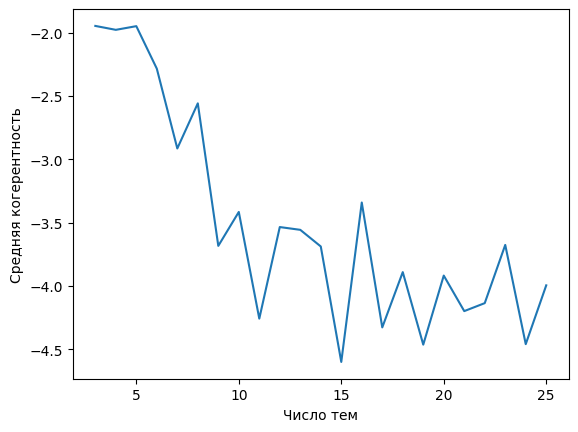

In [26]:
topics_list = list(range(3, 26))
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=150, update_every=1, passes=3)
    coherences.append(CoherenceModel(model=lda, texts=df['preprocessed_text'], dictionary=dictionary, coherence='u_mass').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Выбираю оптимальным делить вопросы на 6 тем.

In [27]:
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=6, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [28]:
vis_data.topic_info.Category

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


140    Default
179    Default
53     Default
155    Default
415    Default
        ...   
214     Topic6
1       Topic6
272     Topic6
71      Topic6
278     Topic6
Name: Category, Length: 369, dtype: object

In [29]:
topic_names_list = vis_data.topic_info.Category.unique()
topic_names_list

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Default', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5',
       'Topic6'], dtype=object)

In [30]:
for topic_name in topic_names_list[1:]:
  print(list(vis_data.topic_info.loc[vis_data.topic_info.Category == topic_name].Term[:8]))

['телефон', 'ремонт', 'гарантийный', 'номер', 'позвонить', 'звонок', 'сервисный', 'кредит']
['магазин', 'продавец', 'сертификат', 'покупатель', 'продажа', 'упаковка', 'производитель', 'продукция']
['дом', 'наш', 'квартира', 'участок', 'этаж', 'прислать', 'жилой', 'давать']
['помещение', 'код', 'российский', 'федерация', 'федеральный', 'расторжение', 'изменение', 'проведение']
['заказ', 'пункт', 'выдача', 'отменить', 'яндекс', 'доставить', 'курьер', 'клуб']
['ребёнок', 'санитарный', 'улица', 'детский', 'расположить', 'подъезд', 'группа', 'озон']


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Интерпретация:

1. Вопросы, связанные с гарантийными ремонтами и сервисными центрами.
2. Вопросы связанные с упаковкой товаров и сертификатами на товары.
3. Вопросы связанные с недвижимостью.
4. Вопросы связанные с гос органами.
5. Вопросы связанные с маркетплейсами, пунктами выдачи и доставкой.
6. Вопросы связанные с детьми.